# Data volume estimation for datasets

Use it to estimate and check if we have a sufficient amount of data collected for our own dataset.

## For FastAI

*Martina Brachmann <martina.brachmann(at)ri(dot)se>* <br>
*Michael Stein <stein.informatik(at)gmail(dot)com*

In [0]:
!curl -s https://course.fast.ai/setup/colab | bash

In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fastai-v3/'

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *

In [0]:
'''
For having the current dataset size in the csv file.
'''

class DataSetSize(Callback):
  def __init__(self, value):
    super().__init__()
    self.name = "dataset_size"
    self.value = value

  def on_epoch_begin(self, **kwargs):
    pass
        
  def on_epoch_end(self, last_metrics, **kwargs):
    return add_metrics(last_metrics, self.value)

In [0]:
'''
Split all the images in *portions_*, create a new databunch and train the network 
for *fit_one_cycle_*. After training, take the next bigger portion and create a 
new databunch and train the network again. Continue until the databunch includes 
all images. 
In order to increase variance, create new portions *kfolds_*. Thus, take all 
images, shuffle them, create a new portion and train the network. Also forget the 
trained model before each *kfolds_*.
Save the information retrieved for each training in a seperate csv file. Thus,
in case the process stops our we have to add more kfolds, we can just continue 
with the information we have already collected and don't have to start from the 
beginning. To do this, change the values for *portion_start_* and *kfold_start_*
to a value greater than '0'.
The parameter *model_* expects the model, *tfms_* the transformation, *path_* the 
path to the images and *src_* a fastai object with the images. This, 
however, may change in the future.
'''

from random import shuffle
from fastai.callbacks.csv_logger import CSVLogger
from fastai.metrics import error_rate, accuracy

def adaptive_training(path_, src_, tfms_, model_, size_=224, portions_=10, kfolds_=5, portion_start_=0, kfold_start_=0, valid_pct_=0.2, fit_one_cycle_=1):
  
  print('Grab a coffee, this may take a while...\n')

  
  def estimate_batch_size(len_data_batch, max_bs=64):
    if len_data_batch * valid_pct_ > max_bs:
      return int(max_bs)
    else:
      return estimate_batch_size(len_data_batch, max_bs=max_bs/2)
    
  portions = range(portions_)
  kfolds = range(kfolds_)
  
  for i in portions[portion_start_:]:
    
    print("Portion %s" % (i))
    
    acc = []
    for j in kfolds[kfold_start_:]:
      
      data_split = src_.use_partial_data(sample_pct=((100/portions_)*(i+1)/100), seed=None)
      data_len = len(data_split)
      bs = estimate_batch_size(data_len)
      
      data = (data_split.split_by_rand_pct(valid_pct_)
              .label_from_folder() # --> FIXME: other solution?
              .transform(tfms_, size=size_)
              .databunch(bs=bs)
              .normalize(imagenet_stats))
      
      learn = cnn_learner(data, model_, metrics=[error_rate, accuracy, DataSetSize(data_len)], callback_fns=[CSVLogger])
      learn.model
      learn.fit_one_cycle(fit_one_cycle_)

      df = learn.csv_logger.read_logged_file()
      
      filename = "history_portion-" + str(i) + "_kfold-" + str(j) + ".csv"
      source = Path(path_/'history.csv')
      target = Path(path_/filename)
      source.rename(target)

In [0]:
'''
Get the path of the images.
'''

path = Path(root_dir + 'data-sets/faces_fake-vs-real');
print(path)

/content/gdrive/My Drive/data-sets/faces_fake-vs-real


In [0]:
tfms = get_transforms()

In [0]:
src = (ImageList.from_folder(path, recurse=True)
       .filter_by_folder(include=['fake', 'real']))
src

ImageList (3974 items)
Image (3, 1024, 1024),Image (3, 1024, 1024),Image (3, 1024, 1024),Image (3, 1024, 1024),Image (3, 1024, 1024)
Path: /content/gdrive/My Drive/data-sets/faces_fake-vs-real

In [12]:
'''
Start the process
'''
adaptive_training(path, src, tfms, models.resnet34, portions_=20, kfolds_=5, portion_start_=0, kfold_start_=0, fit_one_cycle_=4)

Grab a coffee, this may take a while...

Portion 18


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:01<00:00, 85703352.02it/s]


epoch,train_loss,valid_loss,error_rate,accuracy,dataset_size,time
0,0.690617,0.547799,0.254305,0.745695,3775,24:47
1,0.577713,0.451443,0.221192,0.778808,3775,03:15
2,0.472244,0.430207,0.200000,0.800000,3775,03:12
3,0.417228,0.411362,0.197351,0.802649,3775,03:12


epoch,train_loss,valid_loss,error_rate,accuracy,dataset_size,time
0,0.666084,0.504076,0.241060,0.758940,3775,03:57
1,0.567302,0.460359,0.218543,0.781457,3775,03:13
2,0.473554,0.421984,0.202649,0.797351,3775,03:14
3,0.417508,0.421721,0.193377,0.806623,3775,03:14


epoch,train_loss,valid_loss,error_rate,accuracy,dataset_size,time
0,0.723704,0.614461,0.268874,0.731126,3775,03:14
1,0.580773,0.490498,0.225166,0.774834,3775,03:11
2,0.482126,0.453323,0.217219,0.782781,3775,03:11
3,0.412818,0.433679,0.207947,0.792053,3775,03:12


epoch,train_loss,valid_loss,error_rate,accuracy,dataset_size,time
0,0.711582,0.529063,0.243709,0.756291,3775,03:12
1,0.560252,0.458387,0.202649,0.797351,3775,03:12
2,0.470748,0.415676,0.177483,0.822517,3775,03:13
3,0.419135,0.412809,0.174834,0.825166,3775,03:11


epoch,train_loss,valid_loss,error_rate,accuracy,dataset_size,time
0,0.712184,0.493204,0.250331,0.749669,3775,03:13
1,0.565732,0.421494,0.227815,0.772185,3775,02:53
2,0.470374,0.414548,0.207947,0.792053,3775,03:12
3,0.412368,0.392547,0.189404,0.810596,3775,03:12


Portion 19


epoch,train_loss,valid_loss,error_rate,accuracy,dataset_size,time
0,0.684313,0.485702,0.231738,0.768262,3974,03:22
1,0.565830,0.438081,0.205290,0.794710,3974,03:22
2,0.462392,0.375729,0.172544,0.827456,3974,03:20
3,0.417983,0.372508,0.171285,0.828715,3974,03:22


epoch,train_loss,valid_loss,error_rate,accuracy,dataset_size,time
0,0.726338,0.492011,0.238035,0.761965,3974,03:21
1,0.568379,0.440856,0.216625,0.783375,3974,03:22
2,0.464883,0.415495,0.212846,0.787154,3974,03:21
3,0.411591,0.413153,0.209068,0.790932,3974,03:24


epoch,train_loss,valid_loss,error_rate,accuracy,dataset_size,time
0,0.698712,0.546421,0.245592,0.754408,3974,03:21
1,0.565652,0.452180,0.192695,0.807305,3974,03:21
2,0.461328,0.418107,0.191436,0.808564,3974,03:22
3,0.410741,0.408655,0.180101,0.819899,3974,03:22


epoch,train_loss,valid_loss,error_rate,accuracy,dataset_size,time
0,0.709672,0.573800,0.255668,0.744332,3974,03:21
1,0.559682,0.488797,0.209068,0.790932,3974,03:21
2,0.465450,0.445019,0.190176,0.809824,3974,03:23
3,0.404742,0.436595,0.187657,0.812343,3974,03:22


epoch,train_loss,valid_loss,error_rate,accuracy,dataset_size,time
0,0.698029,0.517700,0.240554,0.759446,3974,03:22
1,0.565041,0.438975,0.207809,0.792191,3974,03:22
2,0.478288,0.393479,0.180101,0.819899,3974,03:22
3,0.409881,0.362559,0.153652,0.846348,3974,03:21


In [0]:
'''
Find the csv files that we created during training
'''

# From https://stackoverflow.com/a/9251091

from os import listdir

def find_csv_history_files(path_, suffix=".csv"):
    filenames = listdir(path_)
    return [ path_/filename for filename in filenames if filename.endswith(suffix) and "history_" in filename ]

In [0]:
'''
Read the csv files and retrieve dataset size, mean and standard deviation.
Return these values as pandas dataframe.
'''

from pandas import DataFrame, read_csv
import pandas as pd 

def read_logged_history(history_files):
  dataset_sizes = []
  dataset_prediction = []
  dataset_prediction_std = []
  
  df = pd.DataFrame(columns=['dataset_size', 'dataset_score'], dtype=float)
  
  for i, file in enumerate(history_files):
    df_file = pd.read_csv(str(file))
    df.loc[i] = [df_file.at[len(df_file)-1, 'dataset_size']] + [df_file.at[len(df_file)-1, 'accuracy']]
  
  ts = df.groupby('dataset_size')['dataset_score'].agg([('dataset_score', 'mean'), ('dataset_score_std', 'std')]).reset_index()
  return ts

In [15]:
hist_files = find_csv_history_files(path)
df = read_logged_history(hist_files); df

,dataset_size,dataset_score,dataset_score_std
0,198.0,0.738462,0.068802
1,397.0,0.683544,0.045640
2,596.0,0.685714,0.022705
3,794.0,0.721519,0.048201
4,993.0,0.768687,0.038197
5,1192.0,0.754622,0.042080
6,1390.0,0.776978,0.026311
7,1589.0,0.779180,0.030909
8,1788.0,0.774790,0.019568
9,1987.0,0.791940,0.013865


In [0]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(df["dataset_size"].to_numpy().reshape(-1,1), df["dataset_score"])
df["score_predictions"] = model.predict(df["dataset_size"].to_numpy().reshape(-1,1))

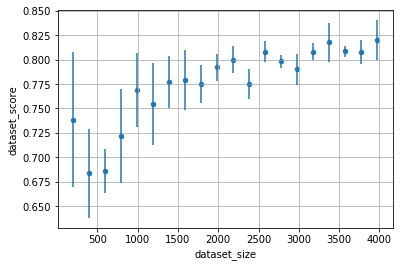

In [17]:
'''
Plot the data with standard deviation.
'''

import matplotlib.pyplot as plt

df.plot.scatter(x="dataset_size", y="dataset_score", yerr="dataset_score_std")
plt.grid(True)
plt.show()

In [19]:
'''
Select the data point until the accuracy increases linear.
'''

lin_datapoints = 4000

df_smaller = df[df["dataset_size"] < lin_datapoints]
df_smaller

,dataset_size,dataset_score,dataset_score_std,score_predictions
0,198.0,0.738462,0.068802,0.719736
1,397.0,0.683544,0.045640,0.725602
2,596.0,0.685714,0.022705,0.731467
3,794.0,0.721519,0.048201,0.737303
4,993.0,0.768687,0.038197,0.743169
5,1192.0,0.754622,0.042080,0.749034
6,1390.0,0.776978,0.026311,0.754870
7,1589.0,0.779180,0.030909,0.760735
8,1788.0,0.774790,0.019568,0.766601
9,1987.0,0.791940,0.013865,0.772466


In [20]:
model.fit(df_smaller["dataset_size"].to_numpy().reshape(-1,1), df_smaller["dataset_score"])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

3974.0


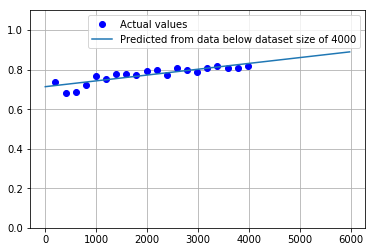

In [21]:
'''
Apply linear regression until the selected data point and plot the values.
'''

print(max(df['dataset_size'].tolist()))

x_model = np.array(range(int(max(df_smaller['dataset_size'].tolist()))+2000)).reshape(-1, 1)
y_model_pred = model.predict(x_model)

plt.plot(df["dataset_size"], df["dataset_score"], 'bo', label="Actual values") #, 'line type', label='label here')
label_ = "Predicted from data below dataset size of " + str(lin_datapoints)
plt.plot(x_model, y_model_pred, label=label_)
plt.ylim(0, 1.1)
plt.grid(True)
plt.legend(loc='best')